First, load the data,in this notebook we are using the PMI data from the paper:"Environmental predictors impact microbialbased postmortem interval (PMI) estimation models within human decomposition soils". The preprocessed data includes OTU/phylum/class/order abundance matrices (includes or not include environmental factors).

This analysis is mainly for the final project of EPP622, and the analysis is different from the previous file in these ways:

1. the data preprocessing is different, previously we "we only consider OTU/ASVs that make up $\ge 1\%$ of the total microbiome community as ``present''", here we will change the threshold to $0.1\%$ based on the paper.

2. To make it simple, only use 16S data and do not consider environmental data.

The new update, use normalized dataset (also removing <0.1% data) for lasso selection, which resulted at less features are selected by Lasso.

This script will use the updated function.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric



In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle
import matplotlib.pyplot as plt
import glob
import os

In [3]:
PMIdata_path = '../data/count_table/'

## No env model
16s (OTU/phylum/class/order) - no env

### Data preprocess


In [4]:
bact_noenv_files = glob.glob(PMIdata_path + 'bact.n.*.noenv.csv')


In [5]:
bact_noenv_files

['../data/count_table/bact.n.otu.noenv.csv',
 '../data/count_table/bact.n.order.noenv.csv',
 '../data/count_table/bact.n.class.noenv.csv',
 '../data/count_table/bact.n.phylum.noenv.csv']

In [6]:
# Read each CSV file into a list of dataframes
bact_noenv_df_list = [pd.read_csv(file) for file in bact_noenv_files]

In [7]:
for df in bact_noenv_df_list:
    print(df.shape)

(78, 5196)
(78, 265)
(78, 112)
(78, 36)


In [8]:
bact_noenv_df_list[3]

,ADH_10_actual,Proteobacteria,Verrucomicrobia,Acidobacteria,Actinobacteria,Firmicutes,Bacteroidetes,Chloroflexi,Rokubacteria,Entotheonellaeota,...,FBP,Fibrobacteres,Hydrogenedentes,Spirochaetes,Tenericutes,Deinococcus-Thermus,Omnitrophicaeota,FCPU426,WS4,Kiritimatiellaeota
0,0.00000,2405.899397,957.553453,1988.986693,2524.409168,92.418396,311.448621,526.359155,123.316076,99.009901,...,1.647876,3.158430,0.686615,0.000000,0.000000,0.000000,2.883784,0.686615,0.000000,0.137323
1,1484.14700,3209.276660,757.215776,1727.647573,1840.003679,226.398320,680.881068,465.059244,117.874278,67.904168,...,0.459848,1.379543,0.459848,0.153283,0.000000,0.000000,1.532825,0.306565,0.000000,0.000000
2,1989.56009,3829.070365,412.942989,821.982537,1300.667694,389.111454,2416.230098,276.938880,48.073960,41.088855,...,0.000000,0.410889,0.616333,0.000000,0.000000,0.000000,0.616333,0.000000,0.000000,0.410889
3,2973.68000,3194.403374,419.280034,848.987596,1688.948376,1069.522046,1868.083981,287.613030,65.055328,42.488288,...,0.622539,2.023252,0.466904,0.000000,0.000000,0.466904,0.311270,0.000000,0.155635,0.000000
4,4027.69203,3694.823154,475.772750,833.851140,1209.230357,465.538458,2514.224448,230.271574,60.065548,51.049624,...,0.731021,0.852858,2.436736,0.000000,0.609184,0.000000,0.487347,0.000000,0.121837,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,4447.32241,2456.386357,702.629879,1096.355563,2612.831828,1416.120207,209.098033,519.102019,161.669485,29.144499,...,0.000000,2.474533,0.000000,0.000000,0.000000,0.000000,0.137474,0.000000,0.000000,0.000000
74,0.00000,2919.908680,1004.519405,1906.070913,954.200252,28.421004,1003.432263,630.853096,87.437295,19.413254,...,1.553060,3.882651,1.863672,1.397754,0.155306,0.000000,4.193263,0.155306,0.621224,1.087142
75,1477.74800,4411.744255,735.145847,1127.142509,1262.559538,178.006467,886.381810,434.238431,128.985155,45.718458,...,0.000000,0.347669,0.173834,0.347669,0.000000,0.173834,0.869172,0.173834,0.521503,0.347669
76,2554.43400,2821.384741,962.492330,1377.965842,1773.368787,586.137247,543.055840,570.541010,179.740233,65.964410,...,0.511352,0.639190,0.894866,0.000000,0.255676,0.000000,0.767028,0.000000,0.127838,0.383514


In [34]:
data_4taxa = []
col_names_4taxa = []
for df in bact_noenv_df_list:
    data = df.drop(df.columns[0], axis=1)
    cols_name = data.columns
    data = data.values
    data =FS.relative_abundance(data,cutOff=0.001)
    data_4taxa.append(data)
    col_names_4taxa.append(cols_name)

In [39]:
col_names_4taxa[i]

Index(['Otu00001', 'Otu00002', 'Otu00003', 'Otu00004', 'Otu00005', 'Otu00006',
       'Otu00007', 'Otu00008', 'Otu00009', 'Otu00010',
       ...
       'Otu06052', 'Otu06065', 'Otu06102', 'Otu06136', 'Otu06221', 'Otu06223',
       'Otu06254', 'Otu06258', 'Otu06314', 'Otu06580'],
      dtype='object', length=5195)

In [10]:
# target variable
y = bact_noenv_df_list[3].iloc[:, 0].values 
y

array([   0.     , 1484.147  , 1989.56009, 2973.68   , 4027.69203,
          0.     , 1026.394  , 1423.473  ,  214.938  ,  493.696  ,
          0.     , 1543.201  , 2970.8    , 3542.968  ,    0.     ,
       1445.51502, 2962.59226, 3504.55394, 4583.2796 ,    0.     ,
       2639.949  , 3573.444  ,    0.     , 1507.78   , 3103.803  ,
       4567.716  ,    0.     , 1510.142  , 2847.791  , 4578.995  ,
          0.     , 1589.377  , 3031.373  , 4512.836  ,    0.     ,
       1502.226  , 3019.923  , 4574.528  ,    0.     , 1364.604  ,
       3009.054  , 3407.734  ,    0.     , 1530.639  , 2949.689  ,
       4391.578  ,    0.     , 1588.226  , 3011.635  , 3976.49   ,
          0.     , 1445.393  , 2999.732  , 4527.275  ,    0.     ,
       1532.17172, 3552.96112, 4474.30808,    0.     , 1329.627  ,
       2854.888  , 4326.392  ,    0.     , 1600.15   , 3024.861  ,
       3985.61   ,    0.     , 1087.43   , 1533.552  ,  510.076  ,
          0.     , 1500.02566, 2988.04838, 4447.32241,    0.  

In [11]:
# Define the threshold
y_threshold = 2500

# Categorize the series based on the threshold
y = np.where(y > y_threshold, 'LONG', 'SHORT')

print(y)

['SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT'
 'SHORT' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'LONG' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG'
 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT'
 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG' 'SHORT' 'SHORT'
 'LONG' 'LONG' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'SHORT' 'LONG'
 'LONG' 'SHORT' 'SHORT' 'LONG' 'LONG']


In [12]:
list(y).count('LONG')

35

In [13]:
list(y).count('SHORT')

43

##### 1. calculate H statistics for OTU/phylum/class/order (both 16s and ITS)

In [14]:
weights_4taxa = []

In [15]:
for df in data_4taxa:
    print(np.shape(df))
    weights=FS.OTU_H_Score_fun(df,y)
    weights_4taxa.append(weights)
    

(78, 5195)
(78, 264)
(78, 111)
(78, 35)


In [16]:
for weight in weights_4taxa:
    print(len(weight))

5195
264
111
35


In [17]:
max(weights_4taxa[3])

35.19309474746626

In [18]:
selectedOTU_index_4tax = []
eps_4tax = []

In [19]:
for weight in weights_4taxa:
    selectedOTU_index, eps=FS.indice_H_unisig(weight,y)
    print(eps)
    selectedOTU_index_4tax.append(selectedOTU_index)
    eps_4tax.append(eps)
    

288
85
44
15


Here, the number of selected features increased for each taxonomic level since we decrease the threshold.

##### 2. Select indices of the features based on H statistics and form the subset based on the selected features.
The default p value of the function is 10%, the resulted index is ranked by its H statistics descendingly.

Use "indice_H_unisig" if there is only one response, use "indice_H_multisig" for multiple responses.

weights_4taxa,selectedOTU_index_4tax,col_names_4taxa,eps_4tax

In [20]:
weights_sig_sorted_4taxa = []
col_names_sig_sorted_4taxa = []
for i in range(len(weights_4taxa)):
    weights_sig_sorted = weights_4taxa[i][selectedOTU_index_4tax[i]]
    col_names_sig_sorted = [col_names_4taxa[i][j] for j in selectedOTU_index_4tax[i]]
    weights_sig_sorted_4taxa.append(weights_sig_sorted)
    col_names_sig_sorted_4taxa.append(col_names_sig_sorted)

In [37]:
selectedOTU_index[1]

2

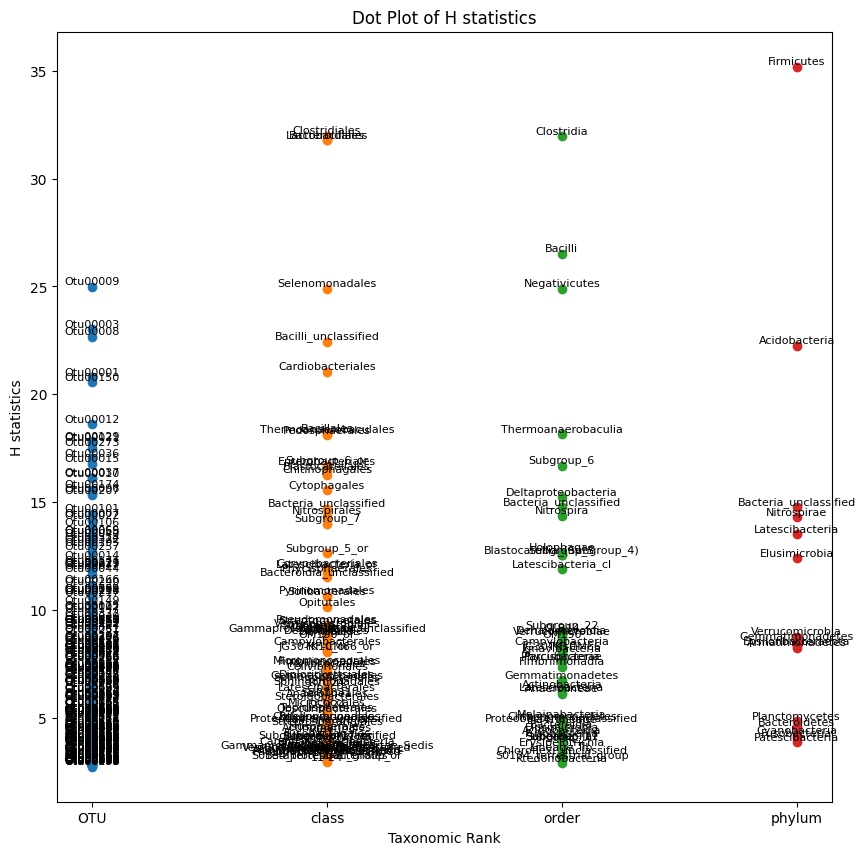

In [21]:
taxlabels = ['OTU', 'class', 'order', 'phylum']

# Assuming weights_sig_sorted_4taxa contains numeric arrays
# Ensure col_names_sig_sorted_4taxa contains the corresponding string labels for each point

plt.figure(figsize=(10, 10))
for i, array in enumerate(weights_sig_sorted_4taxa):
    x_values = [taxlabels[i]] * len(array)  # Label each point with its group (e.g., 'OTU', 'class', etc.)
    plt.scatter(x_values, array, label=f'{taxlabels[i]}')
    
    # Annotate each point with its name from col_names_sig_sorted_4taxa[i][j] and its value
    for j, z in enumerate(array):
        label = col_names_sig_sorted_4taxa[i][j]  # Get the corresponding label for this point
        plt.text(taxlabels[i], z, label, ha='center', va='bottom', fontsize=8, color='black')

plt.title('Dot Plot of H statistics')
plt.xlabel('Taxonomic Rank')
plt.ylabel('H statistics')
plt.show()

In [22]:
#plot the h statistics and cutoff descendingly
#for i in range(len(weights_4taxa)):
    #FS.plotWeightedIndex(weights_4taxa[i],threshold=eps_4tax[i])

In [23]:
data_4taxa[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02616414, 0.00130018, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00235105, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00304625, 0.1548722 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01834826, 0.01637905, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00712766, 0.0403091 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### 4. Model
Prepare 4 datasets: full dataset, our selected dataset, Lasso selected  dataset(based on the target variable), randomly selected data (selected the same numer of variables as in our method)

Use random forest and SVM as classifier, and will build both models for each response variable.

For Lasso, the dataset will be determined by the response variable, so the lasso subset is different for the models for different response variables.

For random selection, the  process will repeat iter=30 times to  find the mean accuracy and AUC

SMOTE  is used (the data is not balanced, as we can see the performance is really bad especially for SVM model when not using SMOTE)

In [24]:
iter =30
cls = ["RF","SVM"]

In [25]:
targetLabel=y

In [52]:
data_subset_4taxa = []
X_lasso_4taxa = []
xind_lasso_4taxa = []
for i, data  in enumerate(data_4taxa):
    X_lasso,xind_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)
    X_lasso_4taxa.append(X_lasso)
    xind_lasso_4taxa.append(xind_lasso)
    data_subset = {"AllFeatures":data, 
               "SelectMicro": data[:,selectedOTU_index_4tax[i]],
               "Lasso":X_lasso,
               "Random":data
              }
    data_subset_4taxa.append(data_subset)

In [53]:
for dataset  in data_subset_4taxa:
    data_subset = dataset
    for datatype, subset in data_subset.items():
        print(np.shape(subset))

(78, 5195)
(78, 288)
(78, 39)
(78, 5195)
(78, 264)
(78, 85)
(78, 16)
(78, 264)
(78, 111)
(78, 44)
(78, 14)
(78, 111)
(78, 35)
(78, 15)
(78, 6)
(78, 35)


In [28]:
#with open('../data/subset_bact_4taxa_noenv_update.pkl', 'wb') as file:
#   pickle.dump(data_subset_4taxa, file)


The  function will print out the accuracy and AUC for each dataset using each classifier, and also will return the y_actual, y_predict, y_predprob for future use.

In [29]:
#dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)

In [30]:
xind_lasso_4taxa

[array([   7,    8,   14,   35,   78,  103,  133,  148,  204,  213,  224,
         270,  273,  274,  279,  319,  358,  416,  461,  470,  520,  557,
         568,  570,  573,  599,  637,  653,  681,  770,  776,  782,  891,
        1027, 1072, 1114, 1119, 1189, 1444]),
 array([  2,   6,   7,  19,  26,  29,  32,  34,  42,  43,  45,  53,  68,
         77,  88, 111]),
 array([ 1,  2,  6, 12, 19, 21, 22, 24, 31, 34, 42, 48, 58, 80]),
 array([ 2,  4, 10, 13, 15, 20])]

In [31]:
col_names_4taxa[3]

['Proteobacteria',
 'Verrucomicrobia',
 'Acidobacteria',
 'Actinobacteria',
 'Firmicutes',
 'Bacteroidetes',
 'Chloroflexi',
 'Rokubacteria',
 'Entotheonellaeota',
 'Nitrospirae',
 'Fusobacteria',
 'Planctomycetes',
 'Bacteria_unclassified',
 'Gemmatimonadetes',
 'Latescibacteria',
 'Epsilonbacteraeota',
 'Dependentiae',
 'Cyanobacteria',
 'Elusimicrobia',
 'BRC1',
 'Armatimonadetes',
 'Patescibacteria',
 'Chlamydiae',
 'WPS-2',
 'WS2',
 'FBP',
 'Fibrobacteres',
 'Hydrogenedentes',
 'Spirochaetes',
 'Tenericutes',
 'Deinococcus-Thermus',
 'Omnitrophicaeota',
 'FCPU426',
 'WS4',
 'Kiritimatiellaeota']

In [32]:
for i in xind_lasso_4taxa[3]:
    print(col_names_4taxa[3][i])

Acidobacteria
Firmicutes
Fusobacteria
Gemmatimonadetes
Epsilonbacteraeota
Armatimonadetes


In [66]:
for i in xind_lasso_4taxa[2]:
    print(col_names_4taxa[2][i])

Clostridia
Alphaproteobacteria
Deltaproteobacteria
Negativicutes
Subgroup_5
Holophagae
Fusobacteriia
Gitt-GS-136
Gemmatimonadetes
Campylobacteria
Planctomycetes_unclassified
Thermoanaerobaculia
Ignavibacteria
Melainabacteria


In [67]:
for i in selectedOTU_index_4tax[2]:
    print(col_names_4taxa[2][i])

Clostridia
Bacilli
Negativicutes
Thermoanaerobaculia
Subgroup_6
Deltaproteobacteria
Bacteria_unclassified
Nitrospira
Holophagae
Subgroup_5
Blastocatellia_(Subgroup_4)
Latescibacteria_cl
Subgroup_22
OLB14
Dehalococcoidia
Verrucomicrobiae
OM190
Campylobacteria
JG30-KF-CM66
TK10
Ignavibacteria
Parcubacteria
Phycisphaerae
Fimbriimonadia
Gemmatimonadetes
Actinobacteria
Latescibacteria
Anaerolineae
Melainabacteria
Chthonomonadetes
Proteobacteria_unclassified
Pla4_lineage
Bacteroidia
Elusimicrobia
Acidobacteriia
Fusobacteriia
Lineage_IIa
Subgroup_17
Subgroup_11
Erysipelotrichia
Lineage_IIb
Chloroflexi_unclassified
S0134_terrestrial_group
Ktedonobacteria


### compare the first 15 index by their present ratio

In [55]:
X_lasso_4taxa[1].shape

(78, 16)

Index(['Otu00009', 'Otu00003', 'Otu00008', 'Otu00001', 'Otu00150', 'Otu00012',
       'Otu00129', 'Otu00021', 'Otu00273', 'Otu00036', 'Otu00015', 'Otu00037',
       'Otu00010', 'Otu00174', 'Otu00096'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
         OTU  presence_pos  presence_neg
0   Otu00009      0.257143      0.790698
1   Otu00003      0.142857      0.000000
2   Otu00008      0.285714      0.000000
3   Otu00001      0.285714      0.093023
4   Otu00150      0.000000      0.000000
5   Otu00012      0.057143      0.000000
6   Otu00129      0.000000      0.000000
7   Otu00021      0.028571      0.000000
8   Otu00273      0.000000      0.000000
9   Otu00036      0.114286      0.000000
10  Otu00015      0.171429      0.023256
11  Otu00037      0.228571      0.046512
12  Otu00010      0.171429      0.023256
13  Otu00174      0.000000      0.000000
14  Otu00096      0.028571      0.000000


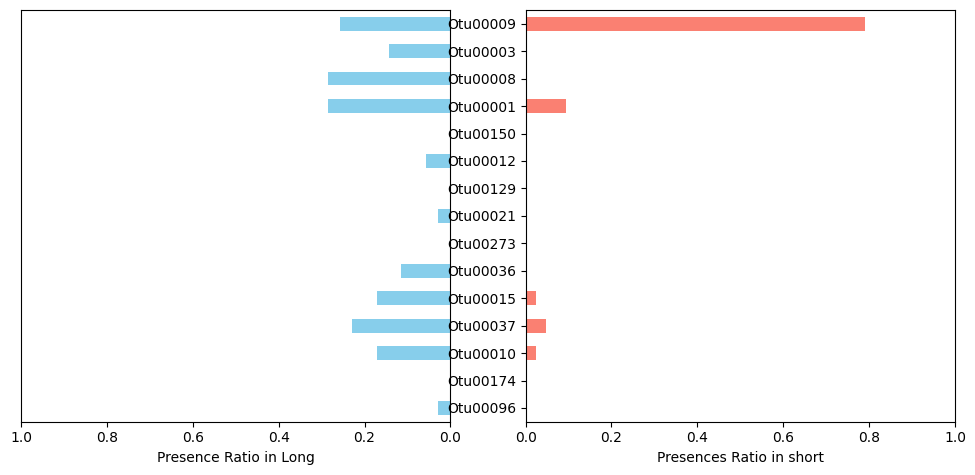

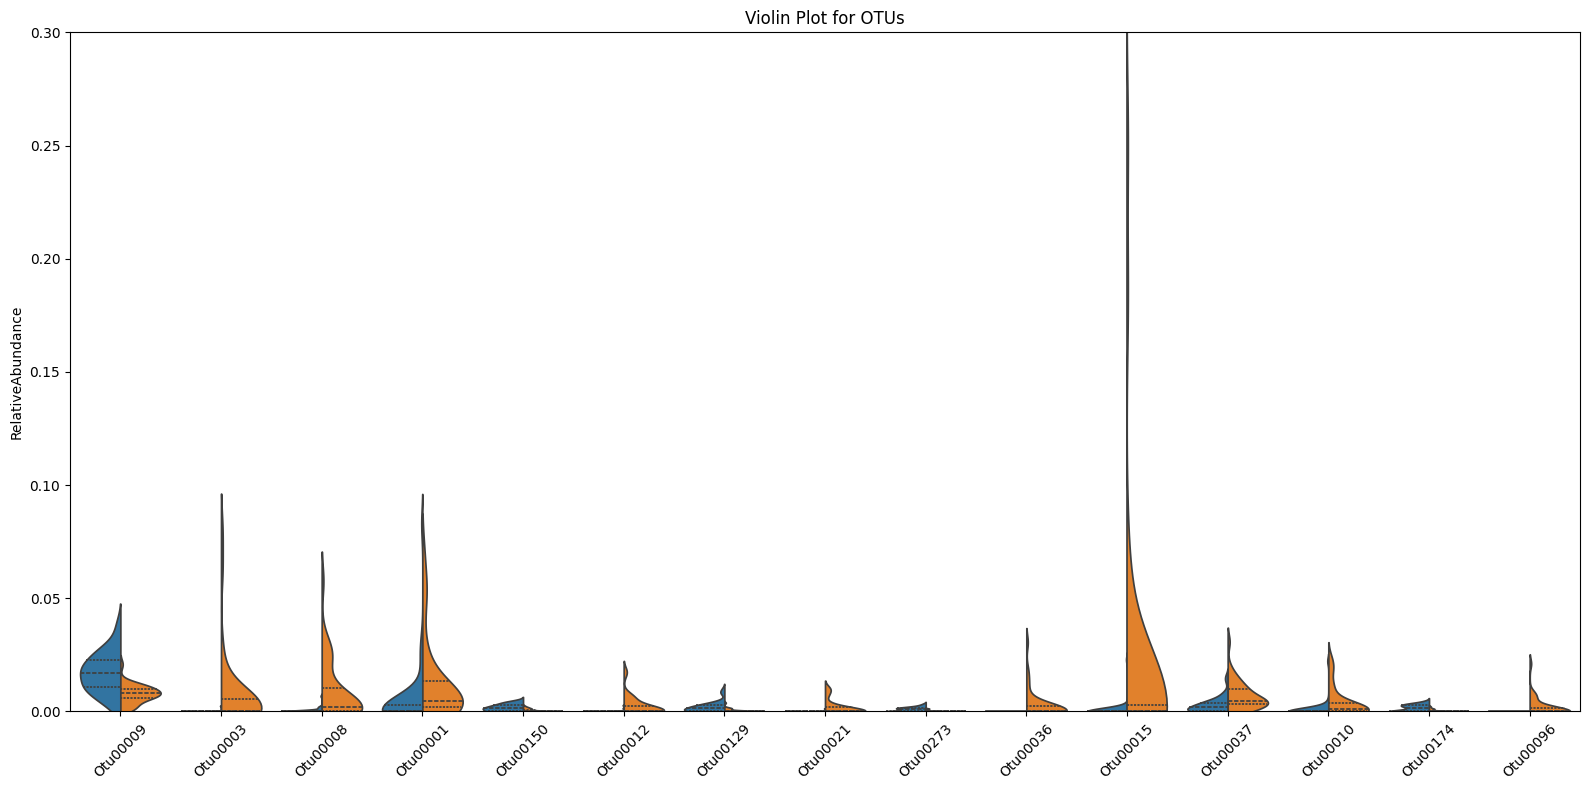

(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
         OTU  presence_pos  presence_neg
0   Otu00008      0.285714      0.000000
1   Otu00009      0.257143      0.790698
2   Otu00015      0.171429      0.023256
3   Otu00037      0.228571      0.046512
4   Otu00081      0.057143      0.000000
5   Otu00106      0.085714      0.000000
6   Otu00136      0.028571      0.000000
7   Otu00151      0.000000      0.000000
8   Otu00207      0.000000      0.000000
9   Otu00216      0.000000      0.000000
10  Otu00227      0.000000      0.000000
11  Otu00273      0.000000      0.000000
12  Otu00276      0.000000      0.000000
13  Otu00277      0.000000      0.000000
14  Otu00282      0.000000      0.000000


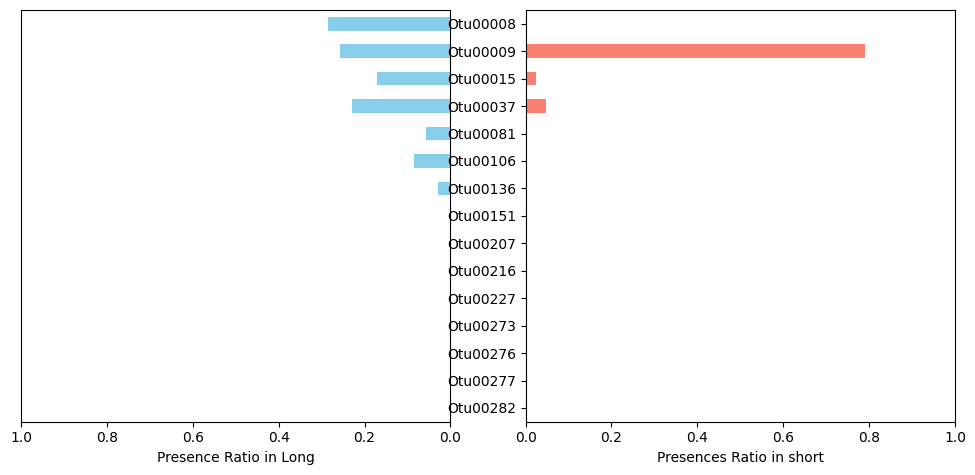

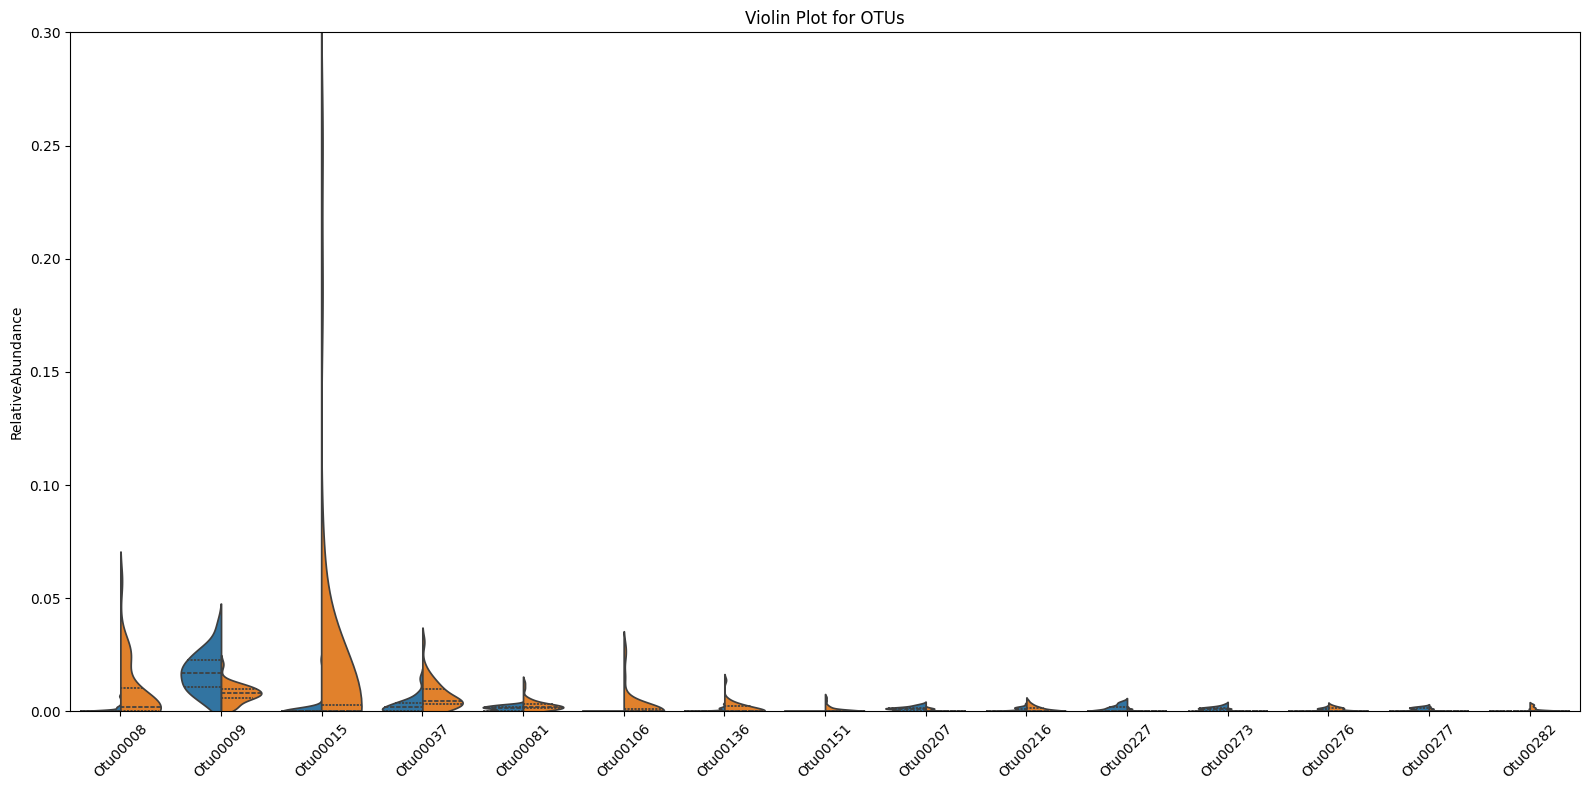

Index(['Clostridiales', 'Bacteroidales', 'Lactobacillales', 'Selenomonadales',
       'Bacilli_unclassified', 'Cardiobacteriales', 'Bacillales',
       'Thermoanaerobaculales', 'Pedosphaerales', 'Subgroup_6_or',
       'Enterobacteriales', 'Blastocatellales', 'Chitinophagales',
       'Cytophagales', 'Bacteria_unclassified'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                      OTU  presence_pos  presence_neg
0           Clostridiales      0.857143      0.325581
1           Bacteroidales      0.228571      0.000000
2         Lactobacillales      0.314286      0.046512
3         Selenomonadales      0.228571      0.000000
4    Bacilli_unclassified      0.257143      0.000000
5       Cardiobacteriales      0.314286      0.093023
6              Bacillales      0.771429      0.372093
7   Thermoanaerobaculales      0.000000      0.000000
8          Pedosphaerales      0.314286      0.767442
9           Subgroup_6_or      0.9428

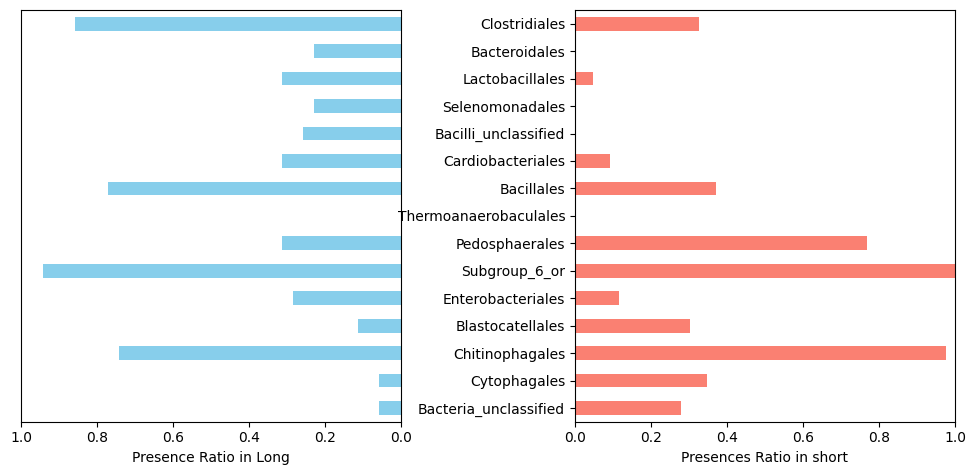

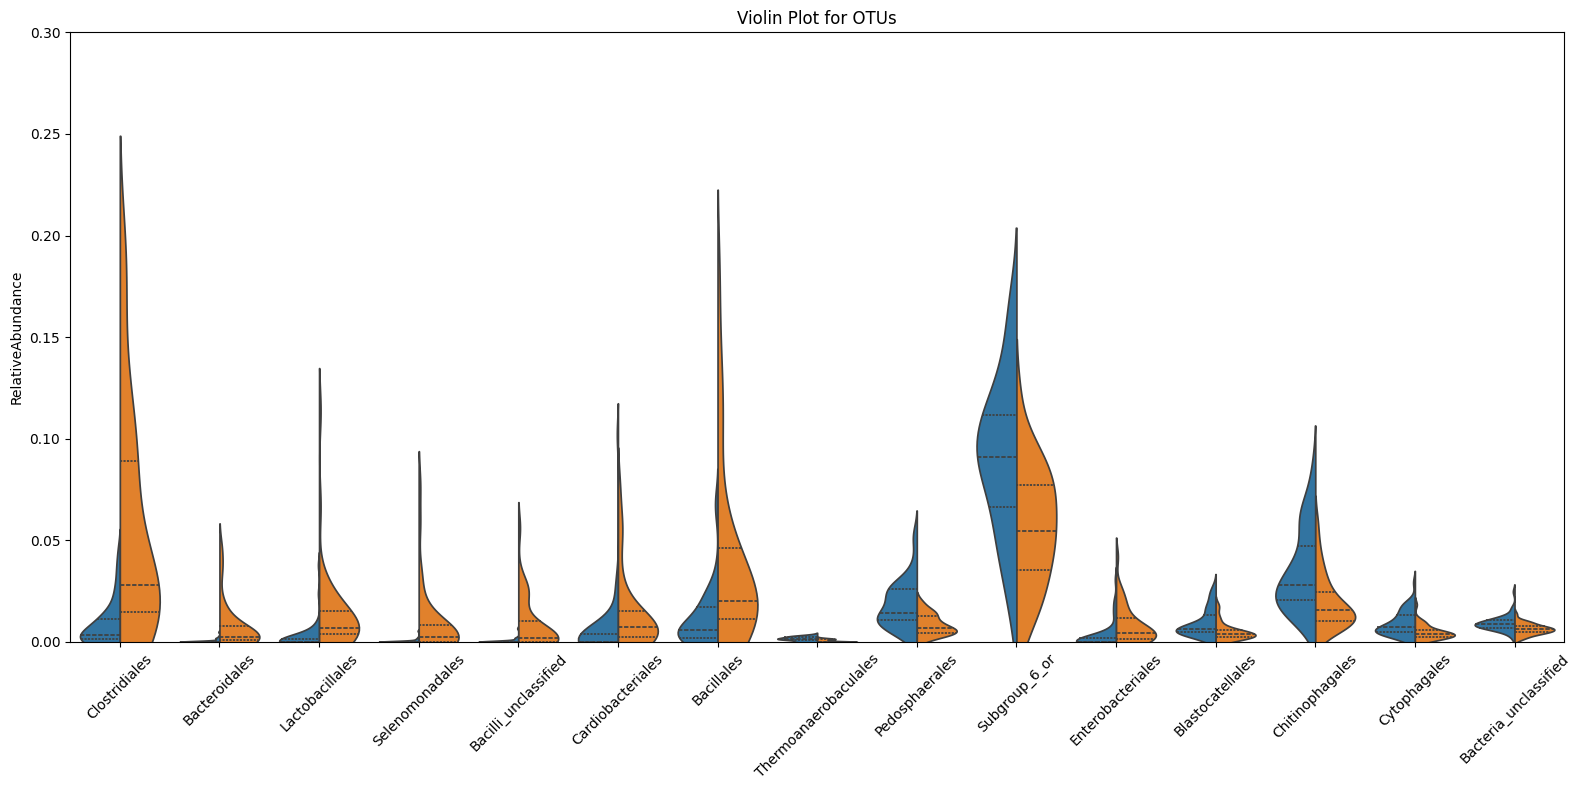

(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                                 OTU  presence_pos  presence_neg
0                      Clostridiales      0.857143      0.325581
1               Bacilli_unclassified      0.257143      0.000000
2                  Corynebacteriales      0.857143      0.558140
3                    Selenomonadales      0.228571      0.000000
4                   Sphingomonadales      0.171429      0.511628
5                Propionibacteriales      0.485714      0.558140
6                     Pedosphaerales      0.314286      0.767442
7                      Reyranellales      0.028571      0.046512
8                      Subgroup_5_or      0.000000      0.000000
9                      Bacteroidales      0.228571      0.000000
10                        Subgroup_7      0.000000      0.023256
11                            PLTA13      0.000000      0.000000
12  Alphaproteobacteria_unclassified      0.000000      0.000000
13               

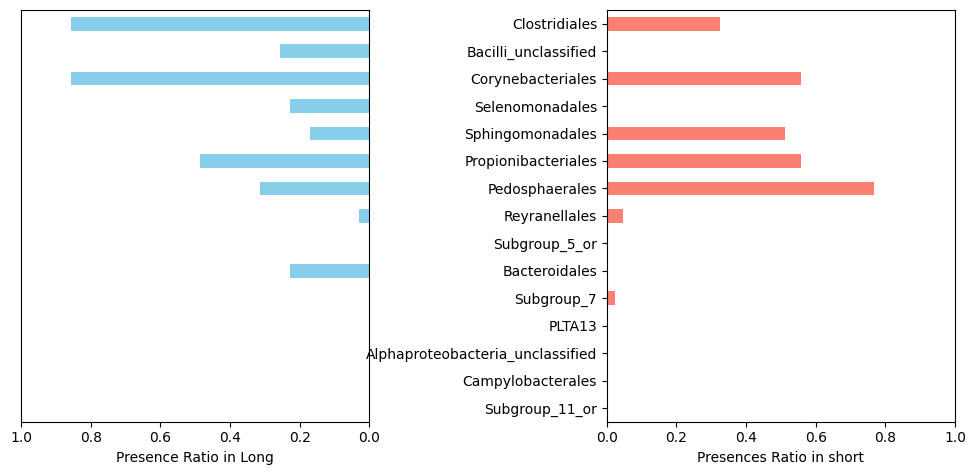

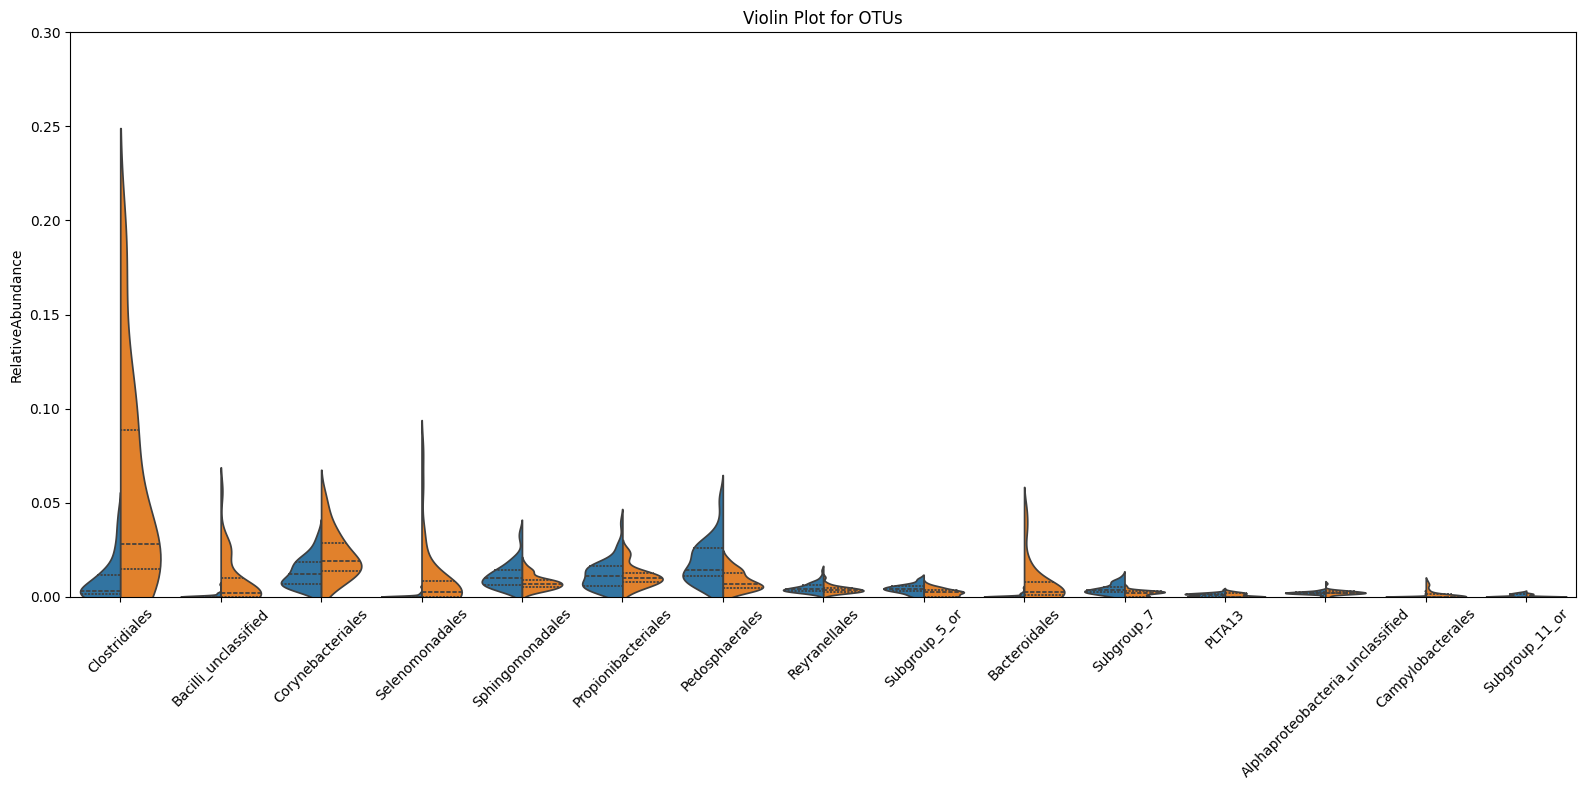

Index(['Clostridia', 'Bacilli', 'Negativicutes', 'Thermoanaerobaculia',
       'Subgroup_6', 'Deltaproteobacteria', 'Bacteria_unclassified',
       'Nitrospira', 'Holophagae', 'Subgroup_5', 'Blastocatellia_(Subgroup_4)',
       'Latescibacteria_cl', 'Subgroup_22', 'OLB14', 'Dehalococcoidia'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                            OTU  presence_pos  presence_neg
0                    Clostridia      0.857143      0.325581
1                       Bacilli      0.914286      0.441860
2                 Negativicutes      0.228571      0.000000
3           Thermoanaerobaculia      0.000000      0.000000
4                    Subgroup_6      0.942857      1.000000
5           Deltaproteobacteria      0.942857      0.976744
6         Bacteria_unclassified      0.057143      0.279070
7                    Nitrospira      0.000000      0.023256
8                    Holophagae      0.000000      0.023256
9          

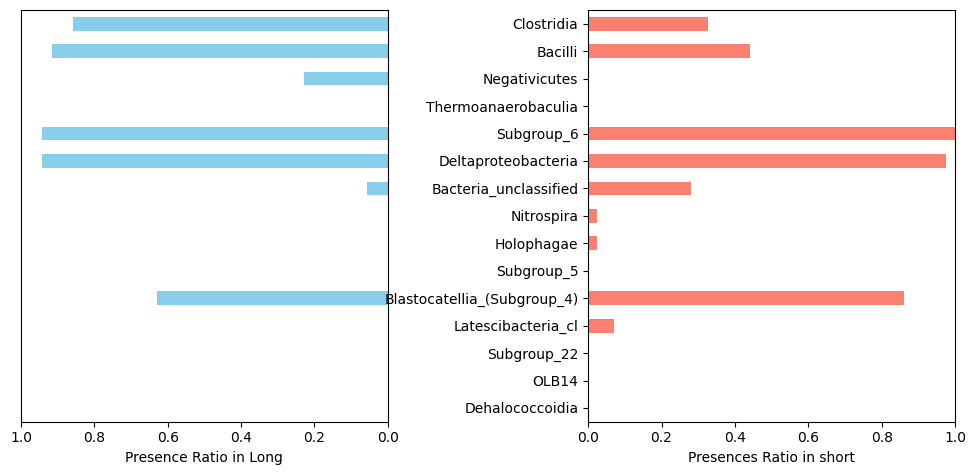

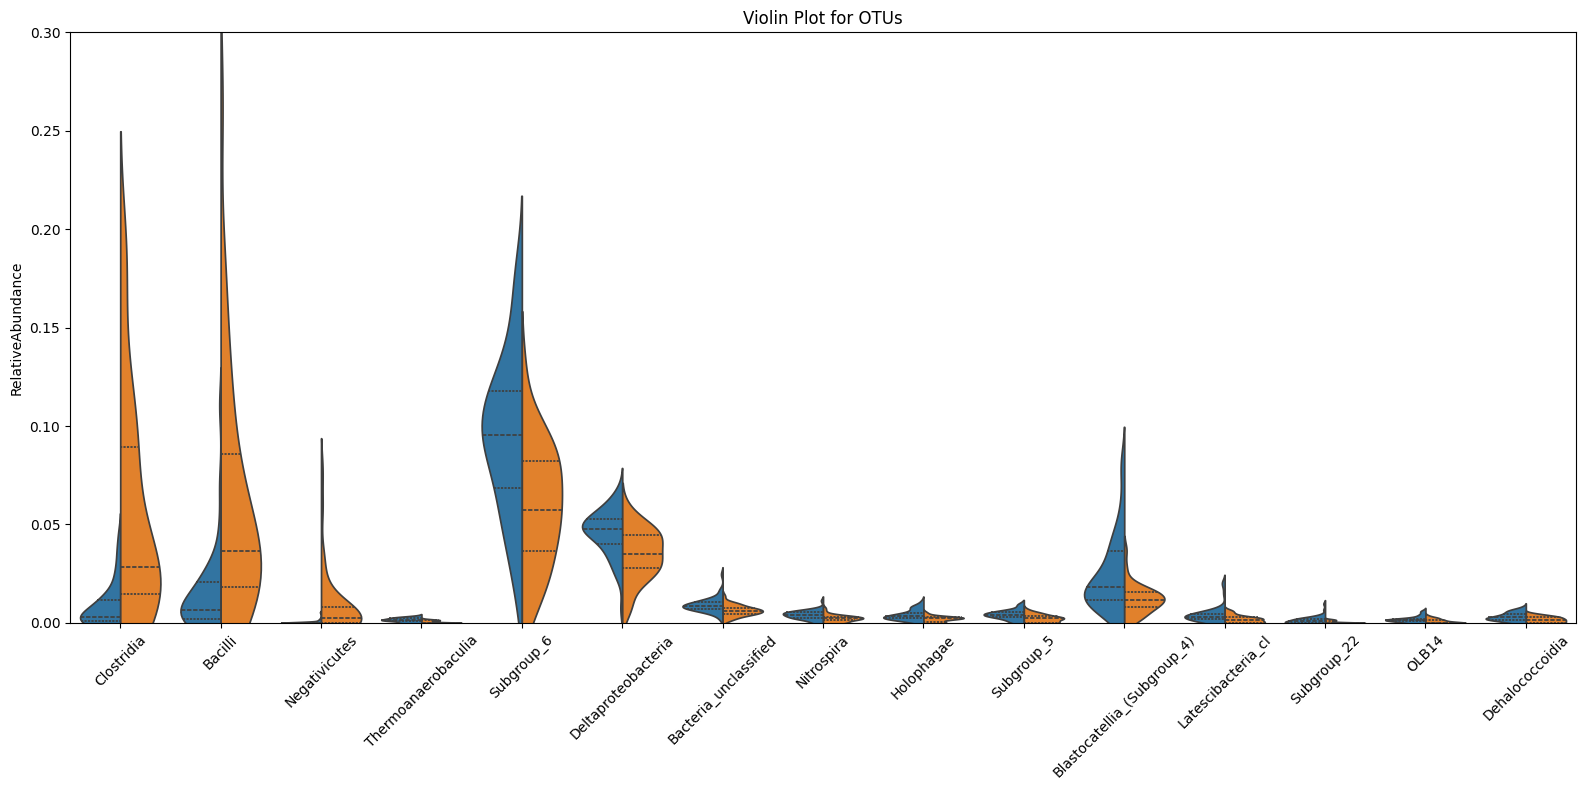

(78, 14)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                            OTU  presence_pos  presence_neg
0                    Clostridia      0.857143      0.325581
1           Alphaproteobacteria      1.000000      1.000000
2           Deltaproteobacteria      0.942857      0.976744
3                 Negativicutes      0.228571      0.000000
4                    Subgroup_5      0.000000      0.000000
5                    Holophagae      0.000000      0.023256
6                 Fusobacteriia      0.057143      0.000000
7                   Gitt-GS-136      0.000000      0.000000
8              Gemmatimonadetes      0.514286      0.674419
9               Campylobacteria      0.000000      0.000000
10  Planctomycetes_unclassified      0.000000      0.000000
11          Thermoanaerobaculia      0.000000      0.000000
12               Ignavibacteria      0.000000      0.000000
13              Melainabacteria      0.000000      0.000000


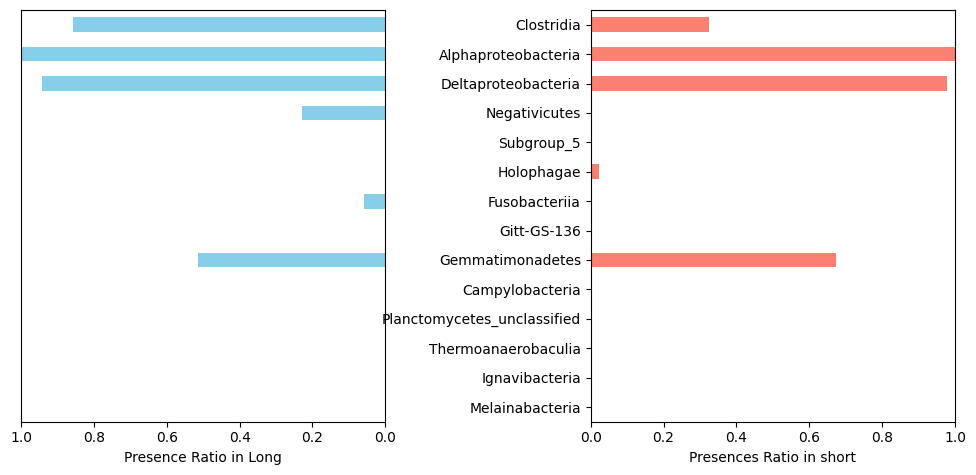

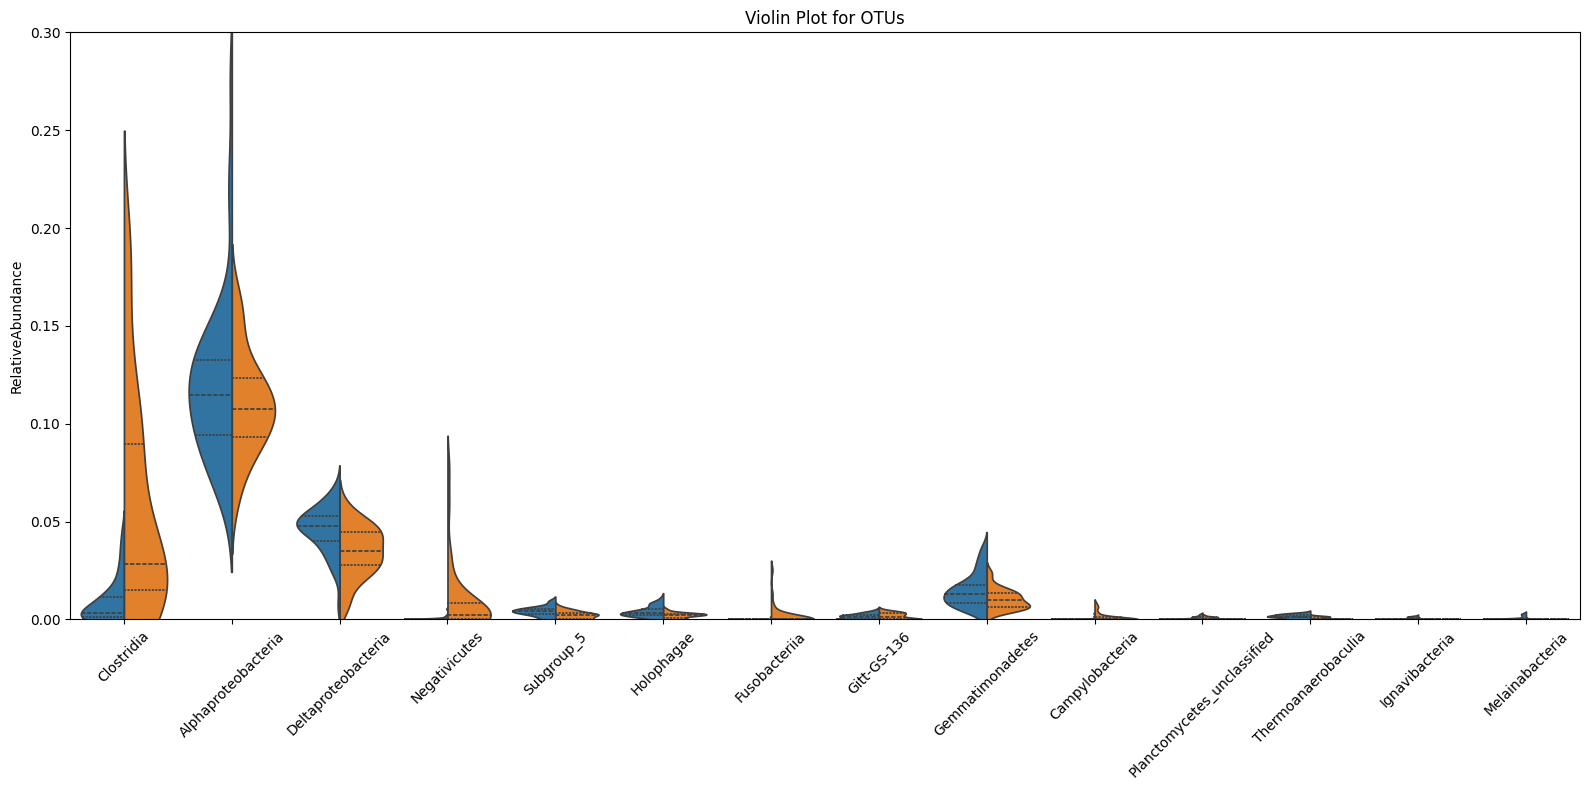

Index(['Firmicutes', 'Acidobacteria', 'Bacteria_unclassified', 'Nitrospirae',
       'Latescibacteria', 'Elusimicrobia', 'Verrucomicrobia',
       'Gemmatimonadetes', 'Epsilonbacteraeota', 'Armatimonadetes',
       'Planctomycetes', 'Bacteroidetes', 'Cyanobacteria', 'Fusobacteria',
       'Patescibacteria'],
      dtype='object')
(78, 15)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                      OTU  presence_pos  presence_neg
0              Firmicutes      1.000000      0.558140
1           Acidobacteria      0.971429      1.000000
2   Bacteria_unclassified      0.057143      0.279070
3             Nitrospirae      0.000000      0.023256
4         Latescibacteria      0.000000      0.069767
5           Elusimicrobia      0.000000      0.000000
6         Verrucomicrobia      1.000000      1.000000
7        Gemmatimonadetes      0.542857      0.697674
8      Epsilonbacteraeota      0.000000      0.000000
9         Armatimonadetes      0.000000      0.000000
1

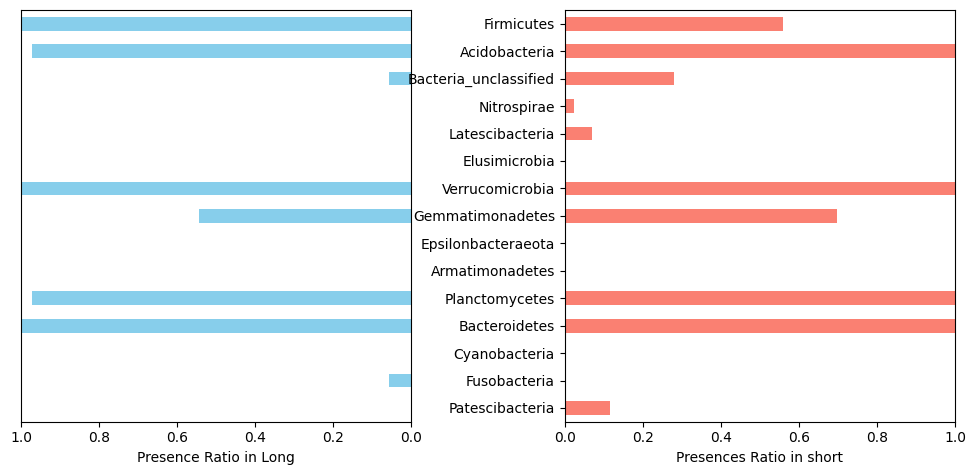

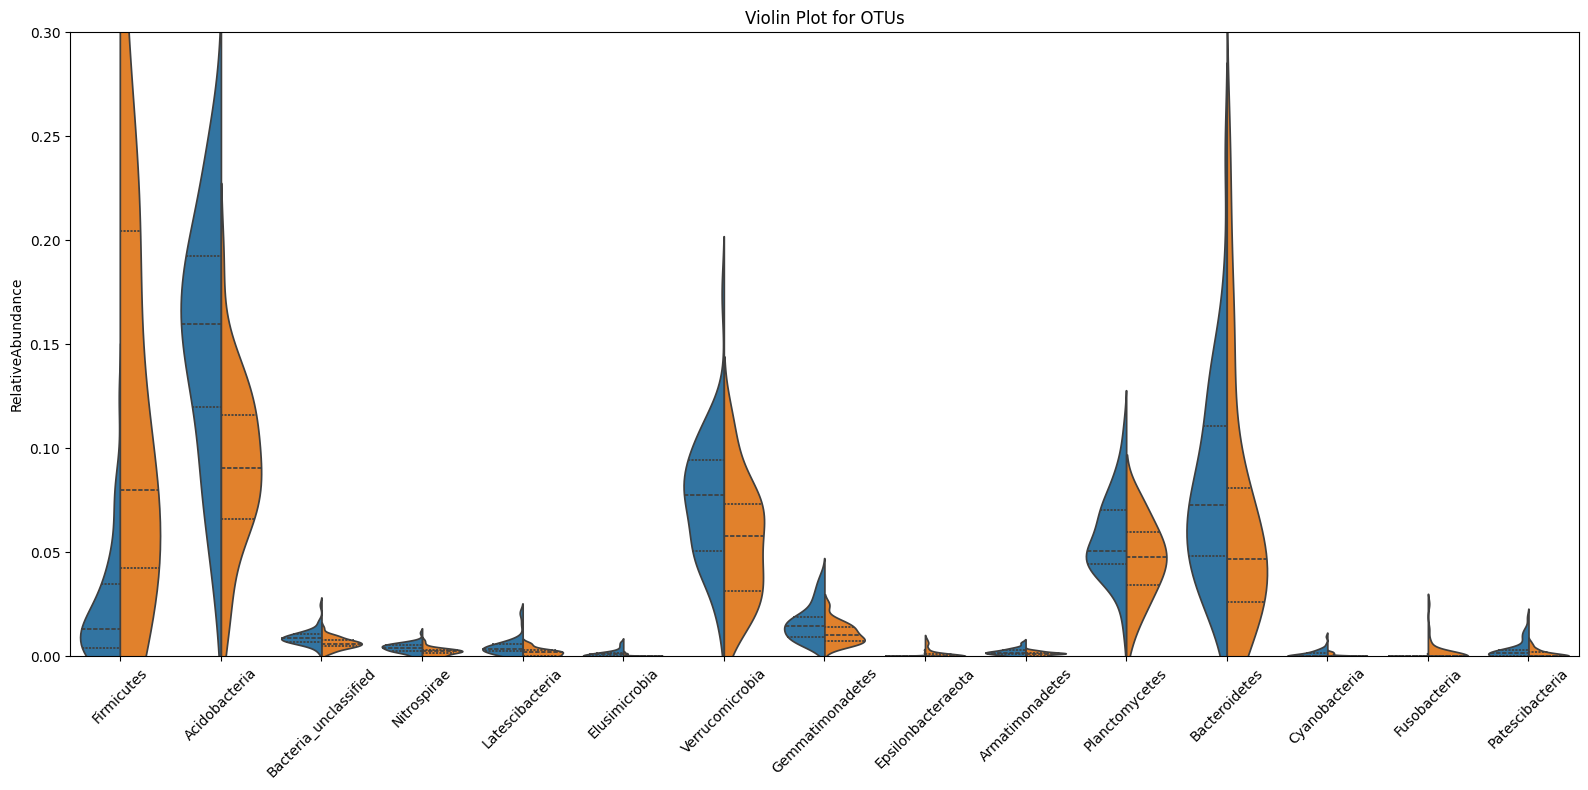

(78, 6)
Validation passed: Dimensions are correct.
Long= 35, short = 43
                  OTU  presence_pos  presence_neg
0       Acidobacteria      0.971429      1.000000
1          Firmicutes      1.000000      0.558140
2        Fusobacteria      0.057143      0.000000
3    Gemmatimonadetes      0.542857      0.697674
4  Epsilonbacteraeota      0.000000      0.000000
5     Armatimonadetes      0.000000      0.000000


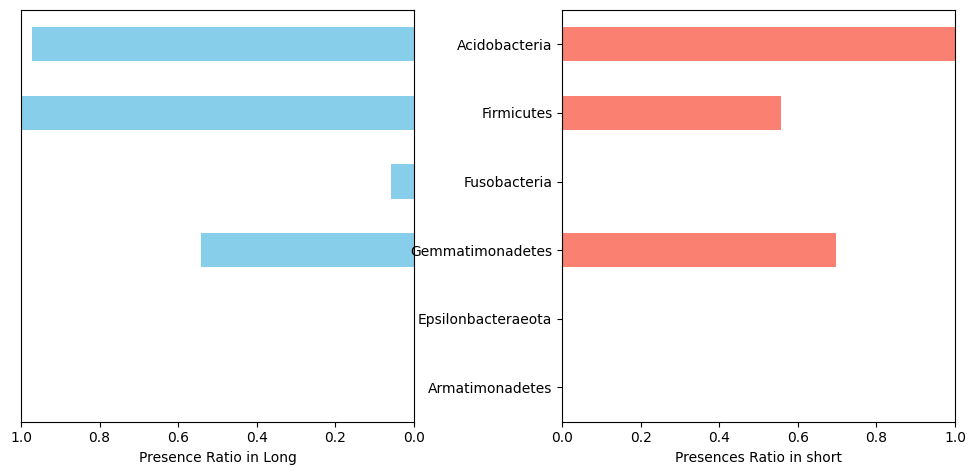

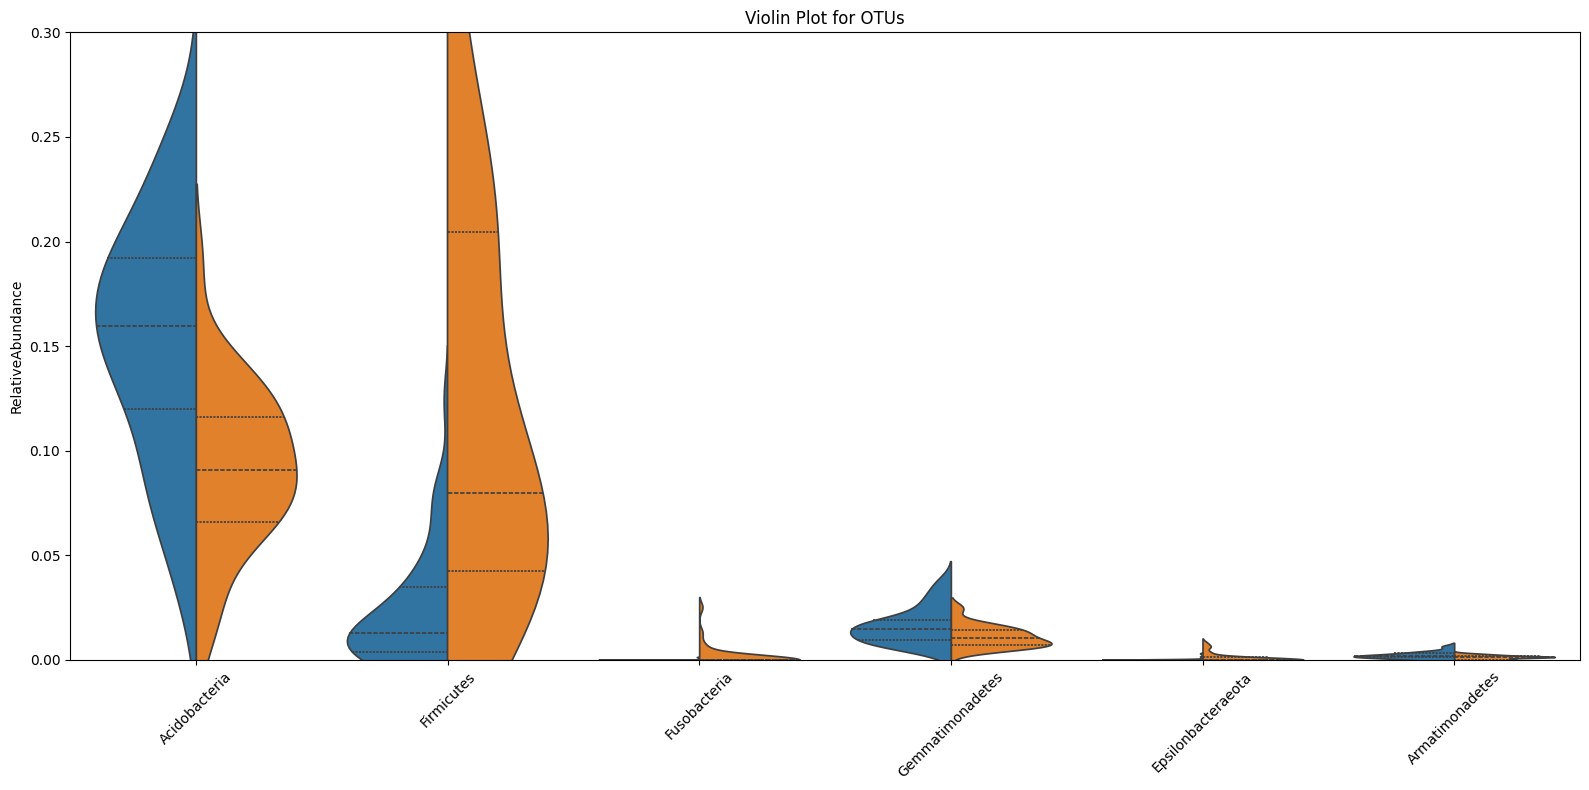

In [64]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

entries=15

for i, data0 in enumerate(data_4taxa):
    selectedOTU_index_15=selectedOTU_index_4tax[i][:entries]
    selectedASVs_15 = col_names_4taxa[i][selectedOTU_index_15]
    print(selectedASVs_15)
    X_FS_15= data0[:,selectedOTU_index_15]
    print(X_FS_15.shape)
    #df=pd.DataFrame(data=X_FS_15)
    FS.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs_15,posLabel="LONG",posText="Long",negText="short")
    FS.OTUviolin(X_FS_15,targetLabel,selectedASVs_15,y_max=0.3)

    M = min(entries,X_lasso_4taxa[i].shape[1])
    selectedLasso_index_15=xind_lasso_4taxa[i][:M] # select the first M features, no ranking
    selectedlasso_15 = col_names_4taxa[i][selectedLasso_index_15]
    X_lasso_4taxa_15 = data0[:,selectedLasso_index_15]
    print(X_lasso_4taxa_15.shape)

    FS.plotPresenseRatio(X_lasso_4taxa_15,targetLabel,selectedlasso_15,posLabel="LONG",posText="Long",negText="short")
    FS.OTUviolin(X_lasso_4taxa_15,targetLabel,selectedlasso_15,y_max=0.3)

    

### Negative Gini Impurity
Gini Impurity is the probability of incorrectly classifying a randomly chosen element in the dataset if it were randomly labeled according to the class distribution in the dataset. It’s calculated as:

$G = 1- \sum_{i=1}^C p_i^2$

where C is the number of classes. (which means it can be used to measure for multiple level classification)

Here I will use the negative Gini Impurity to measure each OTU, if NG is large (1) which means the OTU only exist in one class, if NG value is small($1/c$) which means the OTU is evenly distributed among  the classes.

$NG = \sum_{i=1}^C p_i^2$

In [ ]:
np.unique(y, return_counts=True)

In [ ]:
# NG for selected OTU
NG_4tax = []
for i, data  in enumerate(data_4taxa):
    X_FS = data[:,selectedOTU_index_4tax[i]]
    X_lasso = data[:,xind_lasso_4taxa[i]]
    NG_selected = metric.Neg_GINI(X_FS,targetLabel)
    NG_Lasso = metric.Neg_GINI(X_lasso,targetLabel)
    print(NG_selected.shape)
    print(NG_Lasso.shape)
    NG_4tax.append([NG_selected,NG_Lasso])

In [ ]:
# compare the selected and non select by lasso
# Number of subplots
num_plots = len(data_4taxa)

# Create a figure with a grid of subplots
plt.figure(figsize=(4, 4 * num_plots))

# Loop through each index and create a subplot
for i in range(num_plots):
    plt.subplot(num_plots, 1, i + 1)  # (nrows, ncols, index)
    plt.boxplot([NG_4tax[i][0], NG_4tax[i][1]], tick_labels=['SelectMicro', 'Lasso'])
    plt.title(f'NG results of the selected OTU by SelectMicro vs. Lasso - {taxlabels[i]}')
    plt.ylabel('NG')
    plt.grid(axis='y')
# Adjust layout
plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()  # Show all plots at once

#### Analysis of the top features

In [ ]:
for i, label in enumerate(col_names_sig_sorted_4taxa):
    print(taxlabels[i])
    print(label)

Compare the result of paper:



for Phylum, among the 19 16S features selected by the paper, 13 are selected here (we select 15 in total)




<b>'Clostridia'</b>, 'Bacilli', 'Negativicutes', 'Thermoanaerobaculia', 'Subgroup_6', 'Deltaproteobacteria', 'Bacteria_unclassified', 'Nitrospira', 'Holophagae', 'Subgroup_5', 'Blastocatellia_(Subgroup_4)', 'Latescibacteria_cl', 'Subgroup_22', 'OLB14', 'Dehalococcoidia', 'Verrucomicrobiae', 'OM190', 'Campylobacteria', 'JG30-KF-CM66', 'TK10', 'Ignavibacteria', 'Parcubacteria', 'Phycisphaerae', 'Fimbriimonadia', 'Gemmatimonadetes', 'Actinobacteria', 'Latescibacteria', 'Anaerolineae', 'Melainabacteria', 'Chthonomonadetes', 'Proteobacteria_unclassified', 'Pla4_lineage', 'Bacteroidia', 'Elusimicrobia', 'Acidobacteriia', 'Fusobacteriia', 'Lineage_IIa', 'Subgroup_17', 'Subgroup_11', 'Erysipelotrichia', 'Lineage_IIb', 'Chloroflexi_unclassified', 'S0134_terrestrial_group', 'Ktedonobacteria'


<b>'Firmicutes', 'Acidobacteria'</b>, <b>'Bacteria_unclassified'</b>, <b>'Nitrospirae'</b>, '<b>Latescibacteria'</b>, '<b>Elusimicrobia'</b>, <b>'Verrucomicrobia'</b>, <b>'Gemmatimonadetes'</b>, <b>'Epsilonbacteraeota'</b>, '<b>Armatimonadetes'</b>, 'Planctomycetes', '<b>Bacteroidetes'</b>, '<b>Cyanobacteria'</b>, 'Fusobacteria', 'Patescibacteria'


Change threshold to 1%

In [ ]:
data_4taxa_1 = []
col_names_4taxa_1 = []
for df in bact_noenv_df_list:
    data = df.drop(df.columns[0], axis=1)
    cols_name = data.columns.tolist()
    data = data.values
    data =FS.relative_abundance(data,cutOff=0.01)
    data_4taxa_1.append(data)
    col_names_4taxa_1.append(cols_name)

In [ ]:
weights_4taxa_1 = []
for df in data_4taxa_1:
    print(np.shape(df))
    weights=FS.OTU_H_Score_fun(df,targetLabel)
    weights_4taxa_1.append(weights)
    

In [ ]:
max(weights_4taxa_1[3])

In [ ]:
selectedOTU_index_4tax_1 = []
eps_4tax_1 = []

for weight in weights_4taxa_1:
    selectedOTU_index, eps=FS.indice_H_unisig(weight,targetLabel)
    print(eps)
    selectedOTU_index_4tax_1.append(selectedOTU_index)
    eps_4tax_1.append(eps)

In [ ]:
weights_sig_sorted_4taxa_1 = []
col_names_sig_sorted_4taxa_1 = []
for i in range(len(weights_4taxa_1)):
    weights_sig_sorted = weights_4taxa_1[i][selectedOTU_index_4tax_1[i]]
    col_names_sig_sorted = [col_names_4taxa_1[i][j] for j in selectedOTU_index_4tax_1[i]]
    weights_sig_sorted_4taxa_1.append(weights_sig_sorted)
    col_names_sig_sorted_4taxa_1.append(col_names_sig_sorted)

In [ ]:
for i, label in enumerate(col_names_sig_sorted_4taxa_1):
    print(taxlabels[i])
    print(label)

In [ ]:
weights_sig_sorted_4taxa_1[3]

<b>'Firmicutes', 'Acidobacteria', 'Verrucomicrobia', 'Gemmatimonadetes', 'Bacteria_unclassified', 'Planctomycetes', 'Bacteroidetes',</b> 'Entotheonellaeota', 'Patescibacteria'

Some of the features are not selected in the ITS+16S data, this is because the relative abundance is different in these 2 analysis (since the dataset will do normalization based on each sample)

Cpmpared with the low threshold (which will have more features?):

<b>'Firmicutes', 'Acidobacteria'</b>, <b>'Bacteria_unclassified'</b>, <b>'Nitrospirae'</b>, '<b>Latescibacteria'</b>, '<b>Elusimicrobia'</b>, <b>'Verrucomicrobia'</b>, <b>'Gemmatimonadetes'</b>, <b>'Epsilonbacteraeota'</b>, '<b>Armatimonadetes'</b>, 'Planctomycetes', '<b>Bacteroidetes'</b>, '<b>Cyanobacteria'</b>, 'Fusobacteria', 'Patescibacteria'


There is one feature that is selected using a strict threshold:

In [ ]:
indice1 = [col_names_4taxa[3].index('Entotheonellaeota')]
FS.OTU_H_Score_fun(data_4taxa[3][:,indice1],targetLabel)

In [ ]:
indice2 = [col_names_4taxa_1[3].index('Entotheonellaeota')]
FS.OTU_H_Score_fun(data_4taxa_1[3][:,indice2],targetLabel)

In [ ]:
#print(np.column_stack((data_4taxa[3][:,indice1],data_4taxa_1[3][:,indice2],targetLabel)))

In [ ]:
data_subset_4taxa_1 = []
X_lasso_4taxa_1 = []
xind_lasso_4taxa_1 = []
for i, data  in enumerate(data_4taxa_1):
    X_lasso,xind_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)
    X_lasso_4taxa_1.append(X_lasso_4taxa)
    xind_lasso_4taxa_1.append(xind_lasso)
    data_subset = {"AllFeatures":data, 
               "SelectMicro": data[:,selectedOTU_index_4tax[i]],
               "Lasso":X_lasso,
               "Random":data
              }
    data_subset_4taxa_1.append(data_subset)
    


In [ ]:
NG_4tax_1 = []
for i, data  in enumerate(data_4taxa_1):
    X_FS = data[:,selectedOTU_index_4tax_1[i]]
    X_lasso = data[:,xind_lasso_4taxa_1[i]]
    NG_selected = metric.Neg_GINI(X_FS,y)
    NG_Lasso = metric.Neg_GINI(X_lasso,y)
    print(NG_selected.shape)
    print(NG_Lasso.shape)
    NG_4tax_1.append([NG_selected,NG_Lasso])

In [ ]:
# compare the selected and non select by lasso
# Number of subplots
num_plots = len(data_4taxa_1)

# Create a figure with a grid of subplots
plt.figure(figsize=(4, 4 * num_plots))

# Loop through each index and create a subplot
for i in range(num_plots):
    plt.subplot(num_plots, 1, i + 1)  # (nrows, ncols, index)
    plt.boxplot([NG_4tax_1[i][0], NG_4tax_1[i][1]], tick_labels=['SelectMicro', 'Lasso'])
    plt.title(f'NG results of the selected OTU by SelectMicro vs. Lasso - {taxlabels[i]}')
    plt.ylabel('NG')
    plt.grid(axis='y')
# Adjust layout
plt.tight_layout()  # Adjusts the subplots to fit into the figure area.
plt.show()  # Show all plots at once